In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels plotly plotly_express scipy imblearn


     ---------------------------------------- 11.6/11.6 MB 1.9 MB/s eta 0:00:00
     -------------------------------------- 15.9/15.9 MB 896.4 kB/s eta 0:00:00
     ---------------------------------------- 7.8/7.8 MB 2.1 MB/s eta 0:00:00
     ------------------------------------ 294.9/294.9 KB 371.6 kB/s eta 0:00:00
     ---------------------------------------- 11.2/11.2 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 9.9/9.9 MB 838.1 kB/s eta 0:00:00
     ---------------------------------------- 16.1/16.1 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 46.2/46.2 MB 744.3 kB/s eta 0:00:00
     ------------------------------------ 509.2/509.2 KB 626.1 kB/s eta 0:00:00
     ------------------------------------ 347.8/347.8 KB 654.3 kB/s eta 0:00:00
     -------------------------------------- 55.8/55.8 KB 970.4 kB/s eta 0:00:00
     ------------------------------------ 111.1/111.1 KB 807.0 kB/s eta 0:00:00
     ------------------------------------

You should consider upgrading via the 'c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install --upgrade pip


  Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import zscore
from datetime import timedelta
import zipfile
import os
from sklearn.model_selection import train_test_split


In [203]:
# Path to the main ZIP file
main_zip_path = 'WaterDistributionDataset.zip'
extracted_main_dir = 'WaterDistributionDataset'

# Only extract main ZIP if it exists and target directory doesn't exist
if os.path.exists(main_zip_path) and not os.path.exists(extracted_main_dir):
    with zipfile.ZipFile(main_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_main_dir)
    print(f"Extracted main ZIP file to: {extracted_main_dir}")
elif os.path.exists(extracted_main_dir):
    print(f"Directory already exists: {extracted_main_dir}")
else:
    print(f"Main ZIP file not found: {main_zip_path}")

# Path to the sub-ZIP files inside the extracted directory
sub_zip_paths = [
    'WaterDistributionDataset/WaDi.A1_9 Oct 2017.zip',
    'WaterDistributionDataset/WaDi.A2_19 Nov 2019.zip'
]

# Unzip each of the nested ZIP files
for sub_zip_path in sub_zip_paths:
    sub_extract_dir = os.path.splitext(sub_zip_path)[0]
    
    if os.path.exists(sub_zip_path):
        if not os.path.exists(sub_extract_dir):
            with zipfile.ZipFile(sub_zip_path, 'r') as zip_ref:
                zip_ref.extractall(sub_extract_dir)
            print(f"Extracted: {sub_zip_path} to {sub_extract_dir}")
        else:
            print(f"Extraction directory already exists, skipping: {sub_extract_dir}")
    else:
        print(f"Sub-ZIP file not found: {sub_zip_path}")

Directory already exists: WaterDistributionDataset
Extraction directory already exists, skipping: WaterDistributionDataset/WaDi.A1_9 Oct 2017
Extraction directory already exists, skipping: WaterDistributionDataset/WaDi.A2_19 Nov 2019


In [204]:
# Load the datasets
#wadi_14days_path = 'WaterDistributionDataset/WaDi.A2_19 Nov 2019/WADI.A2_19 Nov 2019/WADI_14days_new.csv'
wadi_attack_labels_path = 'WaterDistributionDataset/WaDi.A2_19 Nov 2019/WADI.A2_19 Nov 2019/WADI_attackdataLABLE.csv'

# Read the CSV files into pandas DataFrames
#df_wadi_14days = pd.read_csv(wadi_14days_path)
df = pd.read_csv(wadi_attack_labels_path, header=0)

# Display the first few rows of each dataframe to understand the structure of the data
#print("WADI_14days_new.csv preview:")
#df_wadi_14days.head(20)
# Clean column names
df.columns = df.columns.str.strip()

# Recreate Timestamp safely
'''if 'Timestamp' not in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Date'].astype(str).str.strip() + ' ' + df['Time'].astype(str).str.strip(), errors='coerce')

# Drop rows where timestamp couldn't be parsed
df.dropna(subset=['Timestamp'], inplace=True)

# Check success
print("Timestamp example:", df['Timestamp'].iloc[0])'''



'if \'Timestamp\' not in df.columns:\n    df[\'Timestamp\'] = pd.to_datetime(df[\'Date\'].astype(str).str.strip() + \' \' + df[\'Time\'].astype(str).str.strip(), errors=\'coerce\')\n\n# Drop rows where timestamp couldn\'t be parsed\ndf.dropna(subset=[\'Timestamp\'], inplace=True)\n\n# Check success\nprint("Timestamp example:", df[\'Timestamp\'].iloc[0])'

In [205]:
# Clean column names (remove whitespace)
df.columns = df.columns.str.strip()

# Recreate Timestamp safely with improved error handling
if 'Timestamp' not in df.columns:
    # Ensure Date and Time exist
    if 'Date' not in df.columns or 'Time' not in df.columns:
        raise KeyError("Required columns 'Date' and/or 'Time' not found in DataFrame")
    
    # Convert to string and clean
    date_str = df['Date'].astype(str).str.strip()
    time_str = df['Time'].astype(str).str.strip()
    
    # Handle empty/missing values
    valid_mask = (date_str != '') & (time_str != '') & (date_str != 'NaT') & (time_str != 'NaT')
    
    # Create Timestamp only for valid rows
    df.loc[valid_mask, 'Timestamp'] = pd.to_datetime(
        date_str[valid_mask] + ' ' + time_str[valid_mask],
        errors='coerce'  # Will still coerce any remaining invalid formats to NaT
    )
    
    # Drop rows where timestamp couldn't be parsed
    initial_count = len(df)
    df.dropna(subset=['Timestamp'], inplace=True)
    dropped_count = initial_count - len(df)
    
    if dropped_count > 0:
        print(f"Warning: Dropped {dropped_count} rows with invalid Timestamp values")

# Verify the results
if 'Timestamp' in df.columns:
    print("Successfully created Timestamp column")
    print("Date range:", df['Timestamp'].min(), "to", df['Timestamp'].max())
    print("Example values:")
    print(df['Timestamp'].head())
else:
    print("Failed to create Timestamp column")

C:\Users\israila.dare\AppData\Local\Temp\ipykernel_32344\1920869250.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[valid_mask, 'Timestamp'] = pd.to_datetime(


Successfully created Timestamp column
Date range: 2017-10-09 00:00:00 to 2017-10-11 00:59:00
Example values:
0   2017-10-09
1   2017-10-09
2   2017-10-09
3   2017-10-09
4   2017-10-09
Name: Timestamp, dtype: datetime64[ns]


In [206]:
#move the 'Timestamp' column to the front
df = df[['Timestamp'] + [col for col in df.columns if col != 'Timestamp']]



In [207]:
print("\nWADI_attackdataLABLE.csv preview:")
df.head(20)


WADI_attackdataLABLE.csv preview:


,Timestamp,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
1,2017-10-09,2.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2,2017-10-09,3.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
3,2017-10-09,4.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
4,2017-10-09,5.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
5,2017-10-09,6.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
6,2017-10-09,7.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
7,2017-10-09,8.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
8,2017-10-09,9.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
9,2017-10-09,10.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1


In [208]:
#shape of the dataframes
#print("\nShape of WADI_14days_new.csv:", df_wadi_14days.shape)
print("Shape of WADI_attackdataLABLE.csv:", df.shape)

Shape of WADI_attackdataLABLE.csv: (172801, 132)


In [209]:
# ceckin info of the dataframes
#print("Info of WADI_14days_new.csv:", df_wadi_14days.info())
print("Info of WADI_attackdataLABLE.csv:", df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 172801 entries, 0 to 172800
Columns: 132 entries, Timestamp to Attack LABLE (1:No Attack, -1:Attack)
dtypes: datetime64[ns](1), float64(128), int64(1), object(2)
memory usage: 175.3+ MB
Info of WADI_attackdataLABLE.csv: None


In [210]:
# Check the columns of the dataframes to understand their structure
#print("\nColumns in WADI_14days_new.csv:", df_wadi_14days.columns.tolist())
print("\nColumns in WADI_attackdataLABLE.csv:", df.columns.tolist())


Columns in WADI_attackdataLABLE.csv: ['Timestamp', 'Row', 'Date', 'Time', '1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV', '1_AIT_005_PV', '1_FIT_001_PV', '1_LS_001_AL', '1_LS_002_AL', '1_LT_001_PV', '1_MV_001_STATUS', '1_MV_002_STATUS', '1_MV_003_STATUS', '1_MV_004_STATUS', '1_P_001_STATUS', '1_P_002_STATUS', '1_P_003_STATUS', '1_P_004_STATUS', '1_P_005_STATUS', '1_P_006_STATUS', '2_DPIT_001_PV', '2_FIC_101_CO', '2_FIC_101_PV', '2_FIC_101_SP', '2_FIC_201_CO', '2_FIC_201_PV', '2_FIC_201_SP', '2_FIC_301_CO', '2_FIC_301_PV', '2_FIC_301_SP', '2_FIC_401_CO', '2_FIC_401_PV', '2_FIC_401_SP', '2_FIC_501_CO', '2_FIC_501_PV', '2_FIC_501_SP', '2_FIC_601_CO', '2_FIC_601_PV', '2_FIC_601_SP', '2_FIT_001_PV', '2_FIT_002_PV', '2_FIT_003_PV', '2_FQ_101_PV', '2_FQ_201_PV', '2_FQ_301_PV', '2_FQ_401_PV', '2_FQ_501_PV', '2_FQ_601_PV', '2_LS_001_AL', '2_LS_002_AL', '2_LS_101_AH', '2_LS_101_AL', '2_LS_201_AH', '2_LS_201_AL', '2_LS_301_AH', '2_LS_301_AL', '2_LS_401_AH', '2_LS_401_AL', '2_LS_5

In [211]:
# print summary type table
print("\nData Types Summary:\n", df.dtypes.value_counts())


Data Types Summary:
 float64           128
object              2
datetime64[ns]      1
int64               1
Name: count, dtype: int64


In [212]:
# check for missing values in the dataframes
#print("\nMissing values in WADI_14days_new.csv:", df_wadi_14days.isnull().sum())
print("\nMissing values in WADI_attackdataLABLE.csv:", df.isnull().sum())



Missing values in WADI_attackdataLABLE.csv: Timestamp                                0
Row                                      0
Date                                     0
Time                                     0
1_AIT_001_PV                             0
                                        ..
3_P_004_STATUS                           0
LEAK_DIFF_PRESSURE                       0
PLANT_START_STOP_LOG                     0
TOTAL_CONS_REQUIRED_FLOW                 0
Attack LABLE (1:No Attack, -1:Attack)    0
Length: 132, dtype: int64


In [213]:
# Check for missing values in the dataset
# Drop rows with any missing values

df_clean = df.dropna()

# Confirm cleanup
print("New shape:", df.shape)
print("Remaining missing values:", df_clean.isnull().sum()) #.sum())


New shape: (172801, 132)
Remaining missing values: Timestamp                                0
Row                                      0
Date                                     0
Time                                     0
1_AIT_001_PV                             0
                                        ..
3_P_004_STATUS                           0
LEAK_DIFF_PRESSURE                       0
PLANT_START_STOP_LOG                     0
TOTAL_CONS_REQUIRED_FLOW                 0
Attack LABLE (1:No Attack, -1:Attack)    0
Length: 132, dtype: int64


In [214]:
# Identify label column (should be the last one)
label_col = df.columns[-1]
print("\nLabel Distribution:\n", df[label_col].value_counts())


Label Distribution:
 Attack LABLE (1:No Attack, -1:Attack)
 1    162824
-1      9977
Name: count, dtype: int64


In [215]:
df.head()

,Timestamp,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,2017-10-09,1.0,10/09/2017,12:00 am,164.21,0.529486,11.9972,482.48,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
1,2017-10-09,2.0,10/09/2017,12:00 am,164.21,0.529486,11.9972,482.48,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2,2017-10-09,3.0,10/09/2017,12:00 am,164.21,0.529486,11.9972,482.48,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
3,2017-10-09,4.0,10/09/2017,12:00 am,164.21,0.529486,11.9972,482.48,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
4,2017-10-09,5.0,10/09/2017,12:00 am,164.21,0.529486,11.9972,482.48,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1


In [216]:
# --- Time range ---
# Clean column names (strip whitespace)
df.columns = df.columns.str.strip()
print("\nDate Range:", df['Date'].iloc[0], "→", df['Date'].iloc[-1])


Date Range: 10/09/2017 → 10/11/2017


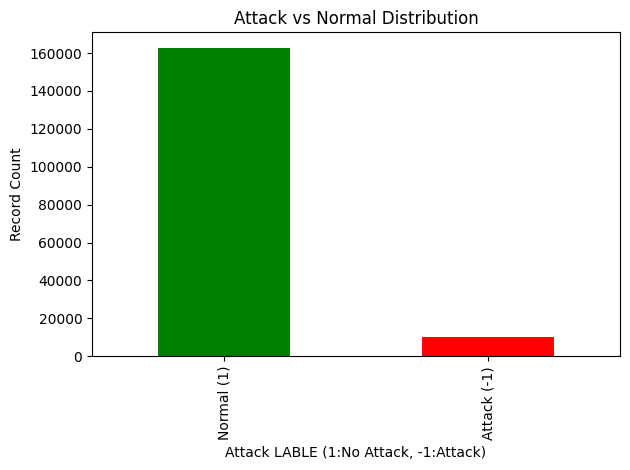

In [217]:
# Plot attack vs. normal frequency
df[label_col].value_counts().plot(kind='bar', title='Attack vs Normal Distribution', color=['green', 'red'])
plt.xticks([0, 1], ['Normal (1)', 'Attack (-1)'])
plt.ylabel('Record Count')
plt.tight_layout()
plt.show()


In [218]:
# Drop explicitly non-numeric columns
non_numeric_cols = ['Row', 'Date', 'Time', df.columns[-1]]  # last column is the label
sensor_df = df.drop(columns=non_numeric_cols, errors='ignore')

# Ensure only numeric columns remain
sensor_df = sensor_df.select_dtypes(include=['float64', 'int64'])

# Compute variance safely
variance = sensor_df.var().sort_values(ascending=False)
top_variance_features = variance.head(10)

print("\nTop 10 High-Variance Sensors:\n", top_variance_features)



Top 10 High-Variance Sensors:
 2B_AIT_002_PV    1.628326e+07
3_AIT_004_PV     4.599468e+05
2_DPIT_001_PV    2.291745e+04
2_FIC_501_CO     1.507820e+03
2_FIC_601_CO     1.488990e+03
2_FIC_301_CO     1.440109e+03
2_FIC_401_CO     1.436019e+03
2_FIC_201_CO     1.368387e+03
2_FIC_101_CO     1.355459e+03
2_MCV_601_CO     5.418308e+02
dtype: float64


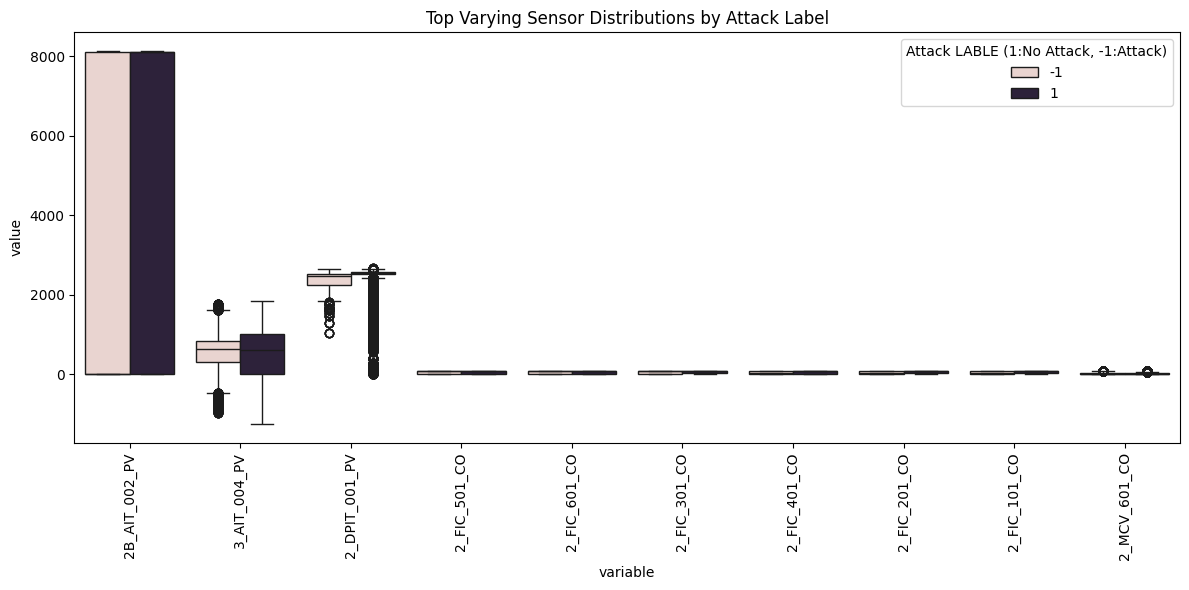

In [219]:
# Boxplot of these features grouped by attack label
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[[*top_variance_features.index, label_col]].melt(id_vars=label_col), 
            x='variable', y='value', hue=label_col)
plt.xticks(rotation=90)
plt.title('Top Varying Sensor Distributions by Attack Label')
plt.tight_layout()
plt.show()

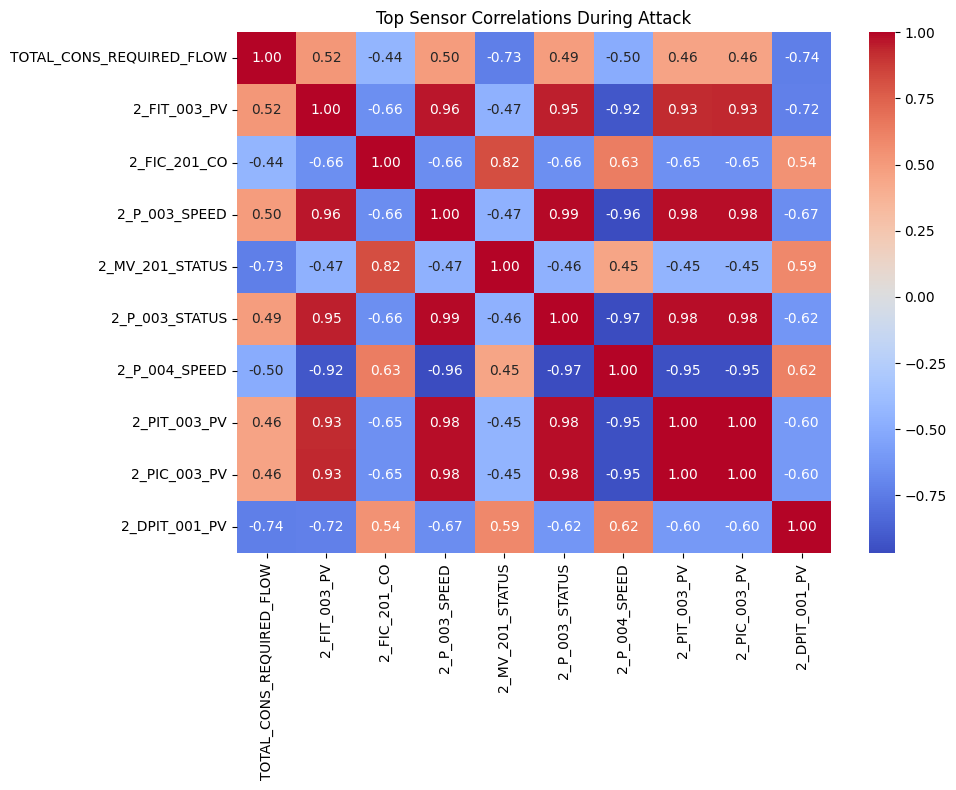

In [220]:
# Correlation matrix during attacks
attack_df = sensor_df[df[label_col] == -1]
corr = attack_df.corr().abs()

# Plot heatmap of top 10 correlated features during attack
top_corr_features = corr.mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(attack_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Sensor Correlations During Attack')
plt.tight_layout()
plt.show()


In [221]:
# Strip column names (if not done already)
#df.columns = df.columns.str.strip()

# Create timestamp column
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop rows where timestamp couldn't be parsed (should be minimal)
df = df.dropna(subset=['Timestamp'])

# Confirm result
print(df[['Timestamp', df.columns[-1]]].head())


C:\Users\israila.dare\AppData\Local\Temp\ipykernel_32344\487050132.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


   Timestamp  Attack LABLE (1:No Attack, -1:Attack)
0 2017-10-09                                      1
1 2017-10-09                                      1
2 2017-10-09                                      1
3 2017-10-09                                      1
4 2017-10-09                                      1


In [222]:
df.head(20)

,Timestamp,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
1,2017-10-09,2.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2,2017-10-09,3.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
3,2017-10-09,4.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
4,2017-10-09,5.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
5,2017-10-09,6.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
6,2017-10-09,7.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
7,2017-10-09,8.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
8,2017-10-09,9.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1
9,2017-10-09,10.0,10/09/2017,12:00 am,164.212,0.547483,11.9946,482.474,0.331282,0.001070,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6153,1.0,0.39,1


In [223]:
# Get attack label column (adjust name if needed)
label_col = df.columns[-2]  # or df.columns[-1] if correct Attack LABLE (1:No Attack, -1:Attack)
if label_col not in df.columns:
    raise KeyError(f"Column '{label_col}' not found. Available columns: {df.columns.tolist()}")

# Convert Timestamp to datetime (if not already)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract date and count attacks per day
df['Day'] = df['Timestamp'].dt.date
attack_per_day = df[df[label_col] == -1]['Day'].value_counts().sort_index()

# Plot (only if attacks exist)
if not attack_per_day.empty:
    plt.figure(figsize=(10, 4))
    attack_per_day.plot(kind='bar', color='red')
    plt.title('Number of Attack Records Per Day')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No attack records (label = -1) found.")

No attack records (label = -1) found.


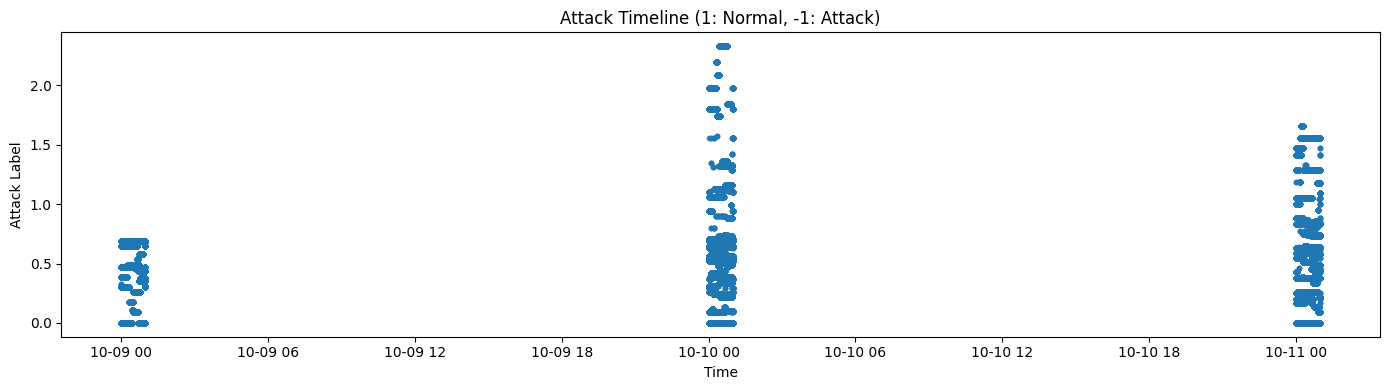

In [224]:
# Plot attack vs normal over time
plt.figure(figsize=(14, 4))
plt.plot(df['Timestamp'], df[label_col], alpha=0.6, marker='.', linestyle='None')
plt.title('Attack Timeline (1: Normal, -1: Attack)')
plt.xlabel('Time')
plt.ylabel('Attack Label')
plt.tight_layout()
plt.show()


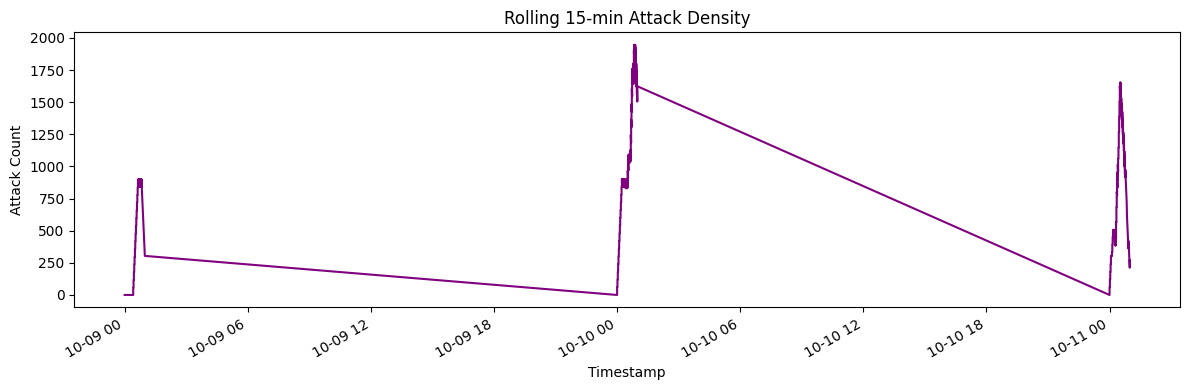

In [225]:
# Get label column name
label_col = df.columns[-2]

# Set and sort time index
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

# Compute rolling 15-minute attack density
attack_density = df[label_col].rolling('15min').apply(lambda x: (x == -1).sum())

# Plot result
plt.figure(figsize=(12, 4))
attack_density.plot(color='purple')
plt.title('Rolling 15-min Attack Density')
plt.ylabel('Attack Count')
plt.tight_layout()
plt.show()


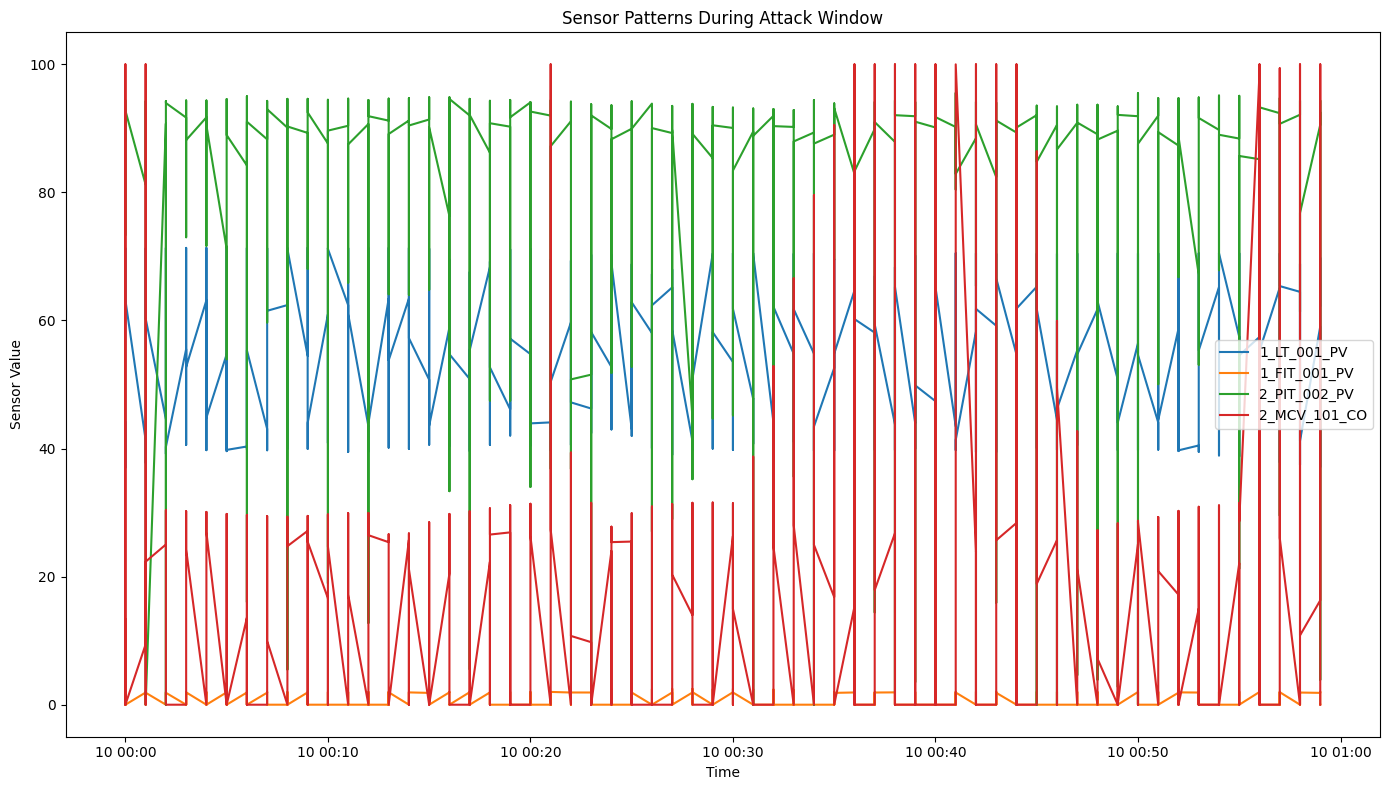

In [226]:
# Define a focused attack time window (adjust based on spikes)
start = '2017-10-09 01:00:00'
end = '2017-10-10 02:30:00'

# Filter data for this window
attack_window_df = df[(df.index >= start) & (df.index <= end)]

# Sensors to inspect
sensors = ['1_LT_001_PV', '1_FIT_001_PV', '2_PIT_002_PV', '2_MCV_101_CO']

# Plot sensors over time
plt.figure(figsize=(14, 8))
for sensor in sensors:
    plt.plot(attack_window_df.index, attack_window_df[sensor], label=sensor)

plt.title('Sensor Patterns During Attack Window')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.tight_layout()
plt.show()


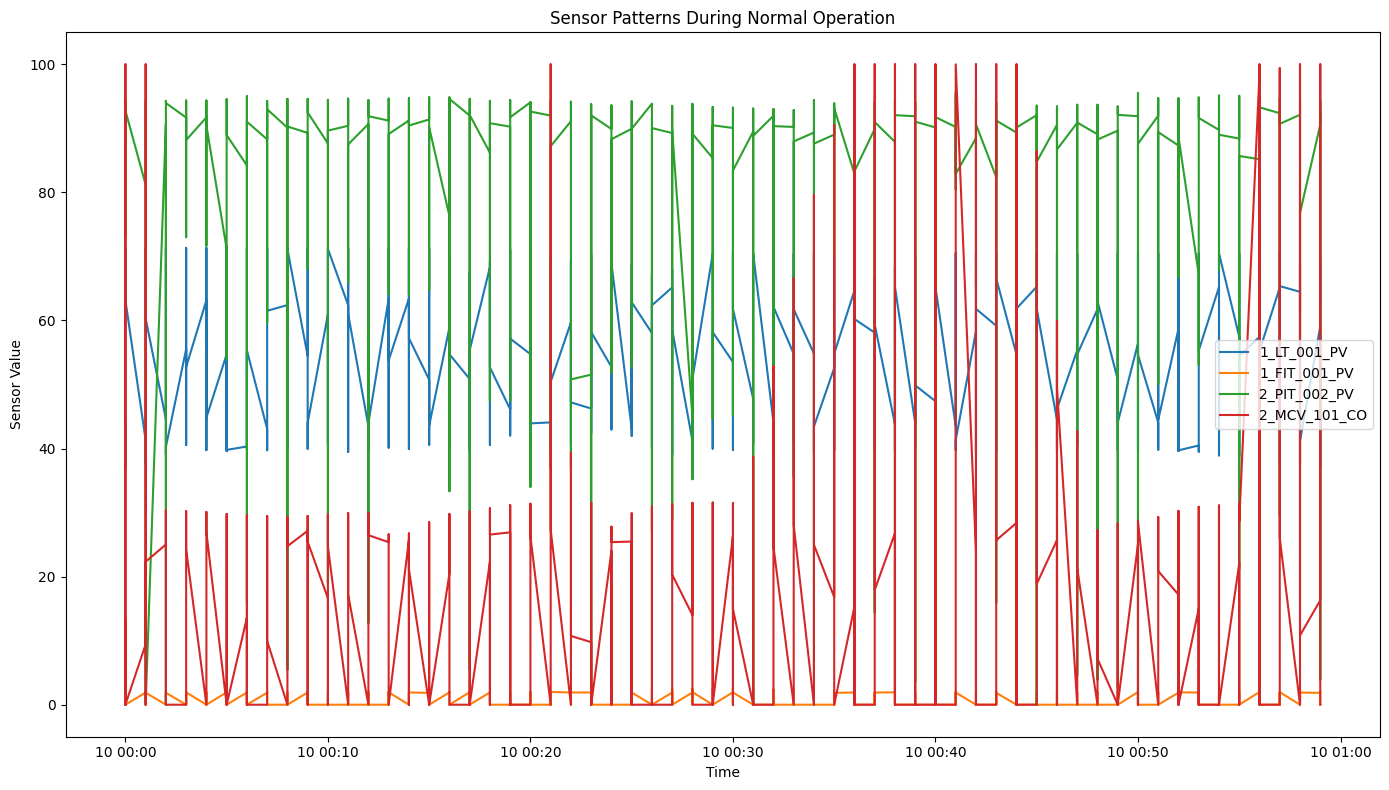

In [227]:
# Select a normal period with no attacks
normal_df = df[(df.index >= '2017-10-09 10:00:00') & (df.index <= '2017-10-10 02:30:00')]

# Plot for comparison
plt.figure(figsize=(14, 8))
for sensor in sensors:
    plt.plot(normal_df.index, normal_df[sensor], label=sensor)

plt.title('Sensor Patterns During Normal Operation')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.tight_layout()
plt.show()


In [228]:
df.head(20)

,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,...,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)",Day
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1,2017-10-09
2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1,2017-10-09
2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1,2017-10-09
2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1,2017-10-09
2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1,2017-10-09
2017-10-09,14421.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1,2017-10-09
2017-10-09,14420.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1,2017-10-09
2017-10-09,14426.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1,2017-10-09
2017-10-09,14419.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,0.0,...,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1,2017-10-09


In [229]:
#move the 'Day' column to the front
df = df[['Day'] + [col for col in df.columns if col != 'Day']]

In [230]:
df.head(20)

,Day,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-09,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09,2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14421.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1
2017-10-09,2017-10-09,14420.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1
2017-10-09,2017-10-09,14426.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14419.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1


In [235]:
# Ensure label column and clean columns
df.columns = df.columns.str.strip()
label_col = df.columns[-1]  # or df.columns[-1] if correct Attack LABLE (1:No Attack, -1:Attack)
if label_col not in df.columns:
    raise KeyError(f"Column '{label_col}' not found. Available columns: {df.columns.tolist()}")
# Sensor data only (exclude Timestamp, Row, Date, Time, label)
exclude_cols = ['Row', 'Date', 'Time', 'Timestamp', 'Day', label_col]
sensor_cols = [col for col in df.columns if col not in exclude_cols]

# Separate attack and normal
attack_data = df[df[label_col] == -1][sensor_cols]
normal_data = df[df[label_col] == 1][sensor_cols]


In [233]:
df.head()

,Day,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-09,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09,2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1


In [ ]:
# Compute mean difference
mean_diff = abs(attack_data.mean() - normal_data.mean()).sort_values(ascending=False)

# Top 10 most shifted sensors
top_sensors = mean_diff.head(10)
print("Top 10 sensors most affected during attacks:\n", top_sensors)


Top 10 sensors most affected during attacks:
 2B_AIT_002_PV    1308.307549
2_DPIT_001_PV     127.293908
3_AIT_004_PV       20.874901
2_MCV_301_CO       20.541194
2_FIC_101_CO       17.849660
2_MCV_601_CO       16.365878
1_AIT_001_PV       12.643945
2_FIC_401_CO       11.212526
2_MCV_007_CO       10.852714
2_MCV_401_CO        9.677555
dtype: float64


In [238]:
df.head(20)

,Day,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-09,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,0.001273,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09,2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14421.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1
2017-10-09,2017-10-09,14420.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1
2017-10-09,2017-10-09,14426.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,0.001171,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2017-10-09,2017-10-09,14419.0,10/09/2017,12:00 am,169.025,0.685467,11.9214,471.670,0.305588,0.001087,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0570,1.0,0.30,1


<Figure size 2000x600 with 0 Axes>

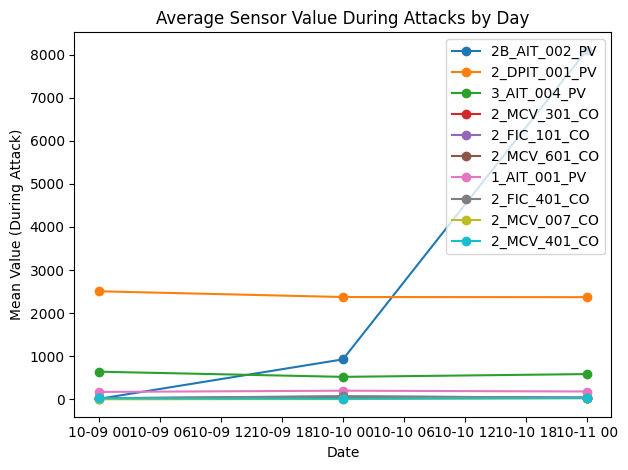

In [241]:
# Ensure 'Timestamp' is back as a column
if df.index.name == 'Timestamp':
    df.reset_index(inplace=True)

# Clean column names
df.columns = df.columns.str.strip()

# Validate and convert Timestamp
if 'Timestamp' not in df.columns:
    raise KeyError("Column 'Timestamp' not found. Available columns: " + str(df.columns.tolist()))

# Convert Timestamp column
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)

# Extract Day
df['Day'] = df['Timestamp'].dt.date

# Group and plot sensor attack patterns
sensor_attack_days = {}
for sensor in top_sensors.index:
    day_summary = df[df[label_col] == -1].groupby('Day')[sensor].mean()
    sensor_attack_days[sensor] = day_summary

# DataFrame and Plot
attack_day_df = pd.DataFrame(sensor_attack_days)
if not attack_day_df.empty:
    plt.figure(figsize=(20, 6))
    attack_day_df.plot(marker='o')
    plt.title('Average Sensor Value During Attacks by Day')
    plt.ylabel('Mean Value (During Attack)')
    plt.xlabel('Date')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("No attack data to plot.")


Top sensor anomalies during attacks (z > 2):


<Figure size 2000x600 with 0 Axes>

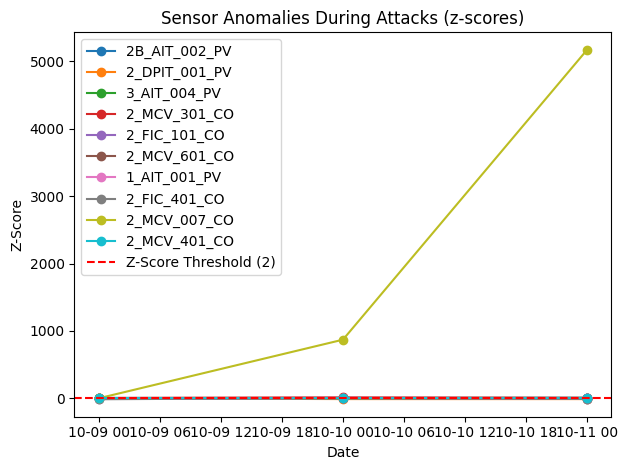

In [247]:
#sensor Anomaly scoring


# Top sensors (already defined as `top_sensors`)
sensor_cols = top_sensors.index.tolist()

# Baseline means/stds from normal data
normal_stats = df[df[label_col] == 1].groupby('Day')[sensor_cols].mean().mean()
normal_std = df[df[label_col] == 1].groupby('Day')[sensor_cols].mean().std()

# Attack-day averages
attack_avg = df[df[label_col] == -1].groupby('Day')[sensor_cols].mean()

# Compute z-scores for attack days
sensor_zscores = (attack_avg - normal_stats) / normal_std

# Display top anomalies (z > 2)
print("Top sensor anomalies during attacks (z > 2):")
#print(sensor_zscores[sensor_zscores > 2].dropna(how='all'))
sensor_zscores[sensor_zscores > 2].dropna(how='all').head(10)
# Plotting the anomalies
plt.figure(figsize=(20, 6))
sensor_zscores.plot(marker='o')
plt.title('Sensor Anomalies During Attacks (z-scores)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.axhline(y=2, color='r', linestyle='--', label='Z-Score Threshold (2)')
plt.legend()
plt.tight_layout()
plt.show()



In [255]:
# Step 1: Extract all attack timestamps
attack_timestamps = df[df[label_col] == -1]['Timestamp']

# Display basic info
print("Total attack rows:", len(attack_timestamps))
print("Attack time range:", attack_timestamps.min(), "to", attack_timestamps.max())

# Show first few unique timestamps
print("\nFirst 15 unique attack timestamps:")
print(attack_timestamps.drop_duplicates().head(15))



Total attack rows: 9977
Attack time range: 2017-10-09 00:25:00 to 2017-10-11 00:59:00

First 15 unique attack timestamps:
9057    2017-10-09 00:25:00
9423    2017-10-09 00:26:00
9728    2017-10-09 00:27:00
10080   2017-10-09 00:28:00
10440   2017-10-09 00:29:00
11038   2017-10-09 00:30:00
11342   2017-10-09 00:31:00
11817   2017-10-09 00:32:00
11880   2017-10-09 00:33:00
12421   2017-10-09 00:34:00
12729   2017-10-09 00:35:00
13142   2017-10-09 00:36:00
13379   2017-10-09 00:37:00
13683   2017-10-09 00:38:00
14280   2017-10-09 00:39:00
Name: Timestamp, dtype: datetime64[ns]


In [260]:

# Step 1: Get attack timestamps
attack_df = df[df[label_col] == -1].copy()
attack_df = attack_df.sort_values('Timestamp')

# Step 2: Detect breaks between continuous attack sequences (gap > 5 minutes)
attack_df['diff'] = attack_df['Timestamp'].diff()
breaks = attack_df['diff'] > timedelta(minutes=2)

# Step 3: Mark groupings and create windows
attack_df['group'] = breaks.cumsum()

attack_windows = []
for _, group in attack_df.groupby('group'):
    start = group['Timestamp'].iloc[0]
    end = group['Timestamp'].iloc[-1]
    attack_windows.append((start, end))

print("Detected Attack Windows:")
for i, (start, end) in enumerate(attack_windows, 1):
    print(f"Attack {i}: {start} → {end}")


Detected Attack Windows:
Attack 1: 2017-10-09 00:25:00 → 2017-10-09 00:50:00
Attack 2: 2017-10-10 00:00:00 → 2017-10-10 00:59:00
Attack 3: 2017-10-11 00:00:00 → 2017-10-11 00:10:00
Attack 4: 2017-10-11 00:16:00 → 2017-10-11 00:47:00
Attack 5: 2017-10-11 00:55:00 → 2017-10-11 00:56:00
Attack 6: 2017-10-11 00:59:00 → 2017-10-11 00:59:00



Top spiking sensors during Attack 1:
2B_AIT_002_PV    3659.922112
3_AIT_004_PV       21.429305
2_DPIT_001_PV      12.275683
2_FIC_101_CO       11.529060
2_FIC_401_CO        8.608893
dtype: float64


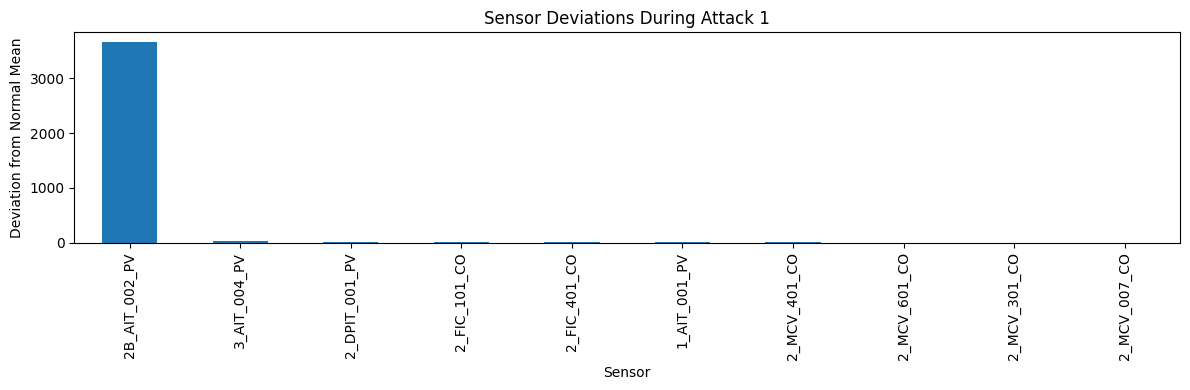


Top spiking sensors during Attack 2:
2B_AIT_002_PV    899.560541
2_DPIT_001_PV     16.232358
3_AIT_004_PV       7.099329
1_AIT_001_PV       2.324785
2_MCV_301_CO       1.916011
dtype: float64


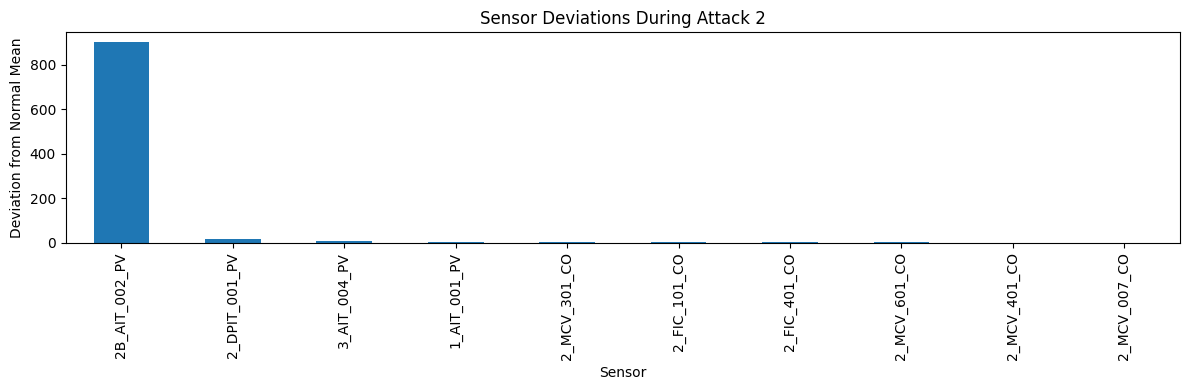


Top spiking sensors during Attack 3:
2B_AIT_002_PV    4443.223594
2_DPIT_001_PV      23.262983
3_AIT_004_PV       17.710601
1_AIT_001_PV        4.538101
2_MCV_401_CO        4.475251
dtype: float64


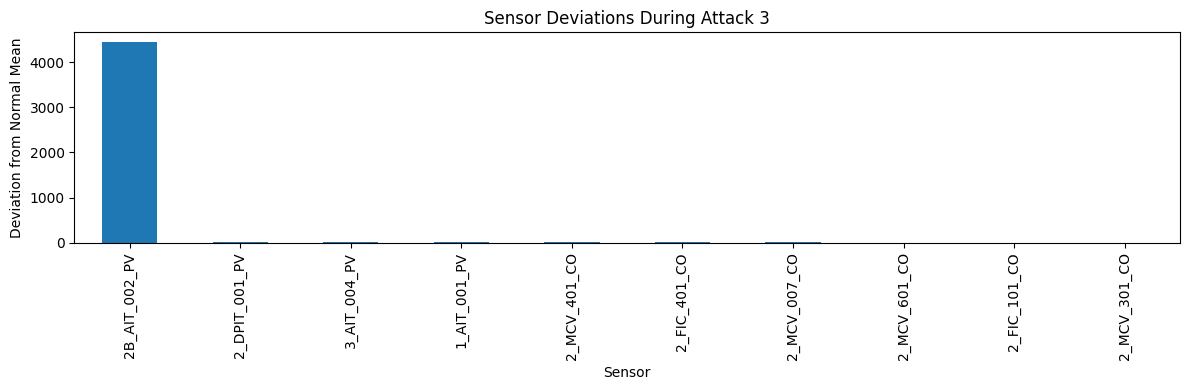


Top spiking sensors during Attack 4:
2B_AIT_002_PV    4443.397899
3_AIT_004_PV       44.105970
2_DPIT_001_PV       4.815276
1_AIT_001_PV        4.666714
2_FIC_101_CO        4.459504
dtype: float64


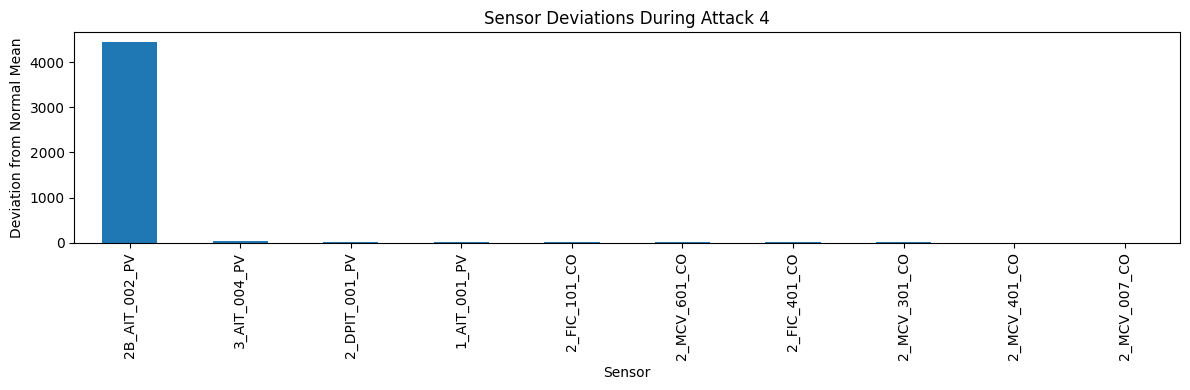


Top spiking sensors during Attack 5:
2B_AIT_002_PV    4440.441076
3_AIT_004_PV       28.882415
2_FIC_101_CO       15.364513
2_MCV_601_CO       11.725332
2_MCV_301_CO       11.002699
dtype: float64


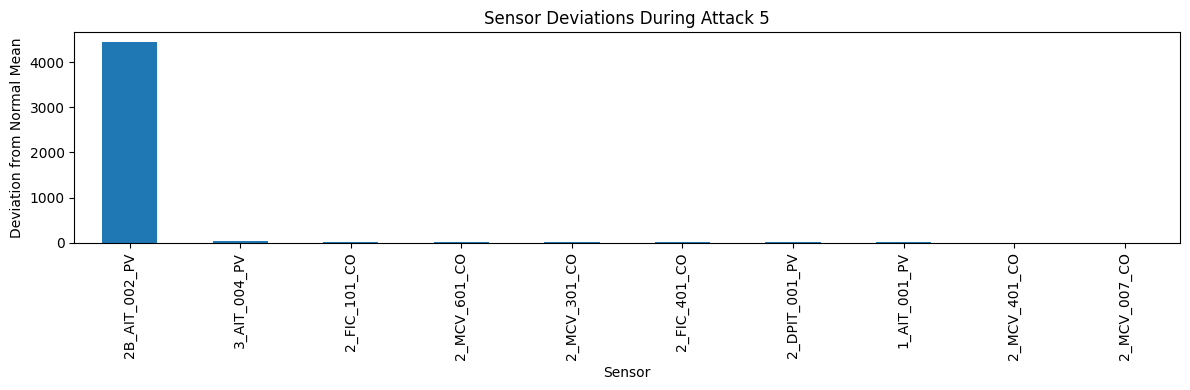


Top spiking sensors during Attack 6:
2B_AIT_002_PV    4441.401590
3_AIT_004_PV       89.764619
2_MCV_601_CO        7.687922
2_FIC_101_CO        6.013988
2_MCV_401_CO        4.717433
dtype: float64


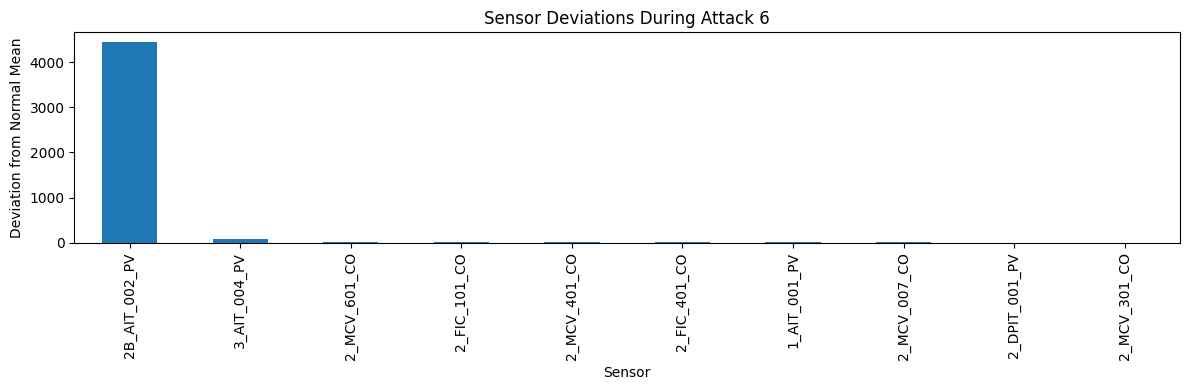

In [261]:
# Step 4: Sensor response per auto-detected attack
for i, (start, end) in enumerate(attack_windows, 1):
    window = df[(df['Timestamp'] >= start) & (df['Timestamp'] <= end)]
    spike_means = window[sensor_cols].mean()
    spike_deltas = (spike_means - normal_stats).abs().sort_values(ascending=False)

    print(f"\nTop spiking sensors during Attack {i}:")
    print(spike_deltas.head(5))

    # Optional bar plot
    plt.figure(figsize=(12, 4))
    spike_deltas.head(10).plot(kind='bar')
    plt.title(f'Sensor Deviations During Attack {i}')
    plt.ylabel('Deviation from Normal Mean')
    plt.xlabel('Sensor')
    plt.tight_layout()
    plt.show()


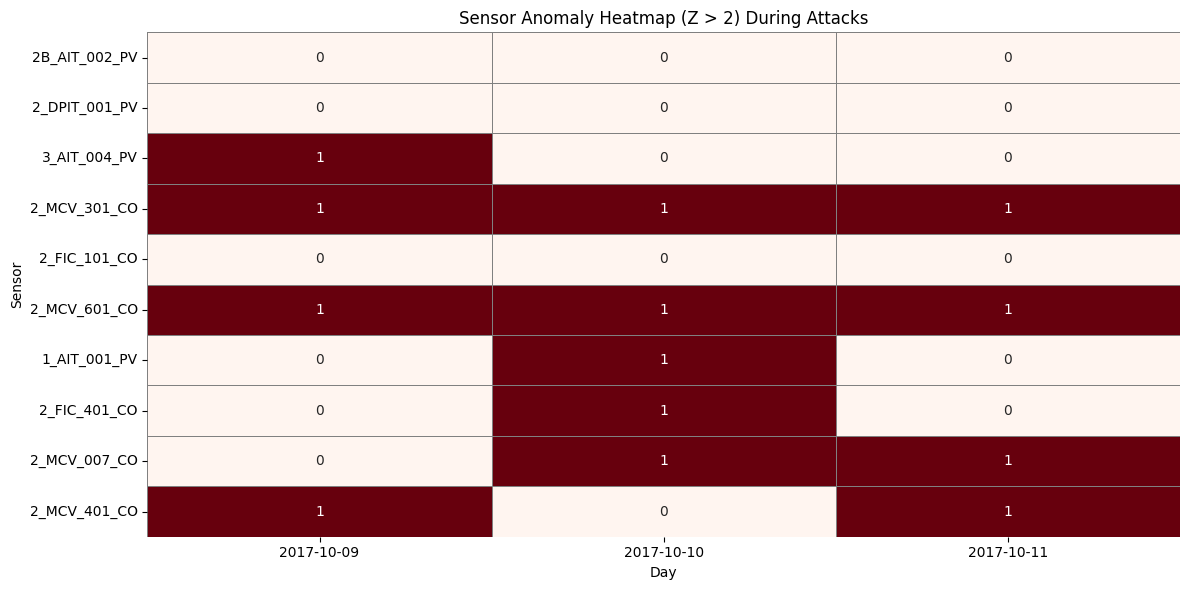

In [262]:
import seaborn as sns
import numpy as np

# Threshold for anomaly (z-score)
threshold = 2
binary_anomalies = (sensor_zscores > threshold).astype(int)

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(binary_anomalies.T, cmap='Reds', linewidths=0.5, linecolor='gray', cbar=False, annot=True)
plt.title("Sensor Anomaly Heatmap (Z > 2) During Attacks")
plt.xlabel("Day")
plt.ylabel("Sensor")
plt.tight_layout()
plt.show()


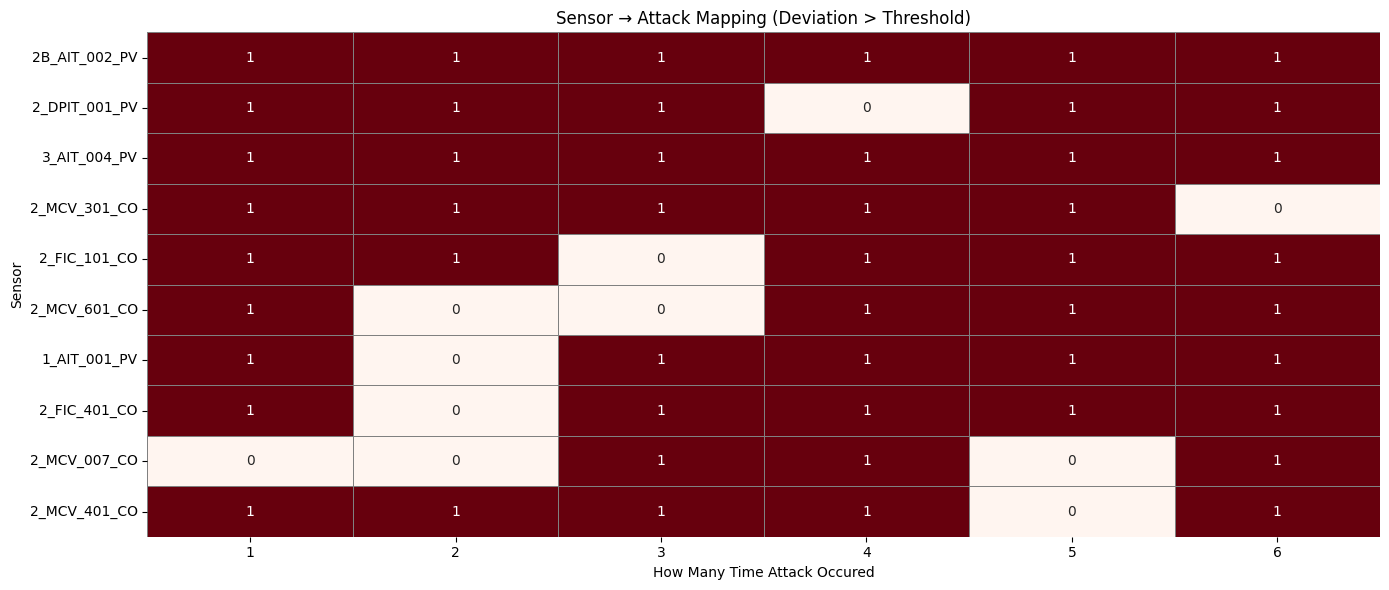

In [267]:
# Recompute baseline (normal) sensor averages
normal_stats = df[df[label_col] == 1][sensor_cols].mean()
# Dictionary to hold sensor impact per attack
sensor_attack_impact = {}

# Loop through detected attack windows
for atk_id, (start, end) in enumerate(attack_windows, 1):
    window_df = df[(df['Timestamp'] >= start) & (df['Timestamp'] <= end)]
    
    if not window_df.empty:
        impact = abs(window_df[sensor_cols].mean() - normal_stats)
        sensor_attack_impact[atk_id] = impact
# Assemble into DataFrame: rows = attack IDs, columns = sensors
impact_df = pd.DataFrame(sensor_attack_impact).T.fillna(0)
impact_df.index.name = "How Many Time Attack Occured"
# Threshold to flag an anomaly (adjust as needed)
threshold = 1

# Convert to binary: 1 if deviation > threshold
binary_impact = (impact_df > threshold).astype(int)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(binary_impact.T, cmap="Reds", annot=True, linewidths=0.5, linecolor="gray", cbar=False)
plt.title("Sensor → Attack Mapping (Deviation > Threshold)")
plt.xlabel("How Many Time Attack Occured")
plt.ylabel("Sensor")
plt.tight_layout()
plt.show()



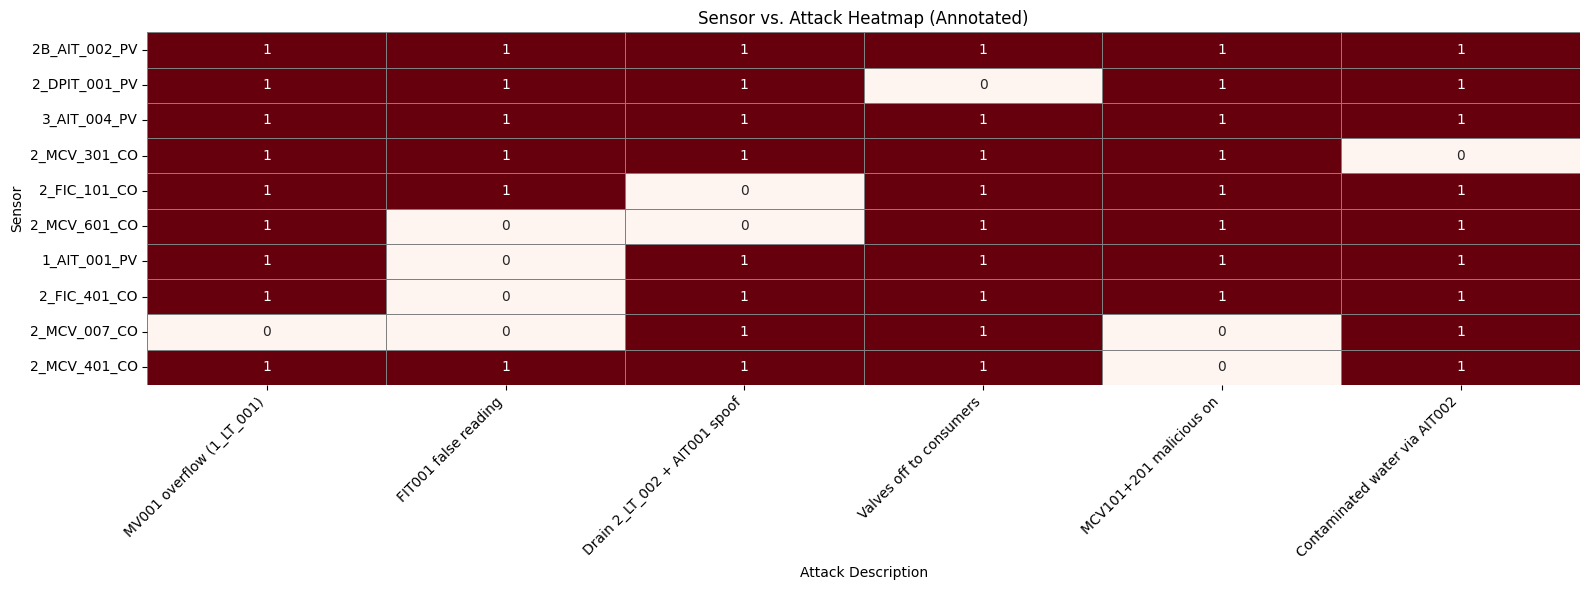

In [268]:
# Human-readable labels (edit/expand as needed)
attack_labels = {
    1: "MV001 overflow (1_LT_001)",
    2: "FIT001 false reading",
    3: "Drain 2_LT_002 + AIT001 spoof",
    4: "Valves off to consumers",
    5: "MCV101+201 malicious on",
    6: "Contaminated water via AIT002",
    7: "Leak via MCV007",
    8: "Pump P006 burst",
    9: "MV001 + pump damage",
    10: "Repeat of leak (MCV007)",
    11: "Repeat of leak (MCV007)",
    12: "Repeat of leak (MCV007)",
    13: "Reduce booster pressure",
    14: "Stop chemical dosing",
    15: "Reverse of Attack 3"
}
# Use attack_labels in the same order as attack_df
label_list = [attack_labels.get(atk, f"Attack {atk}") for atk in binary_impact.index]

# Re-plot with annotations
plt.figure(figsize=(16, 6))
sns.heatmap(binary_impact.T, cmap="Reds", annot=True, linewidths=0.5, linecolor="gray", cbar=False)

plt.title("Sensor vs. Attack Heatmap (Annotated)")
plt.xlabel("Attack Description")
plt.ylabel("Sensor")
plt.xticks(ticks=np.arange(len(label_list)) + 0.5, labels=label_list, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [270]:
#save the dataframe to a csv file
# Optional: set timestamp as column if not already
if 'Timestamp' not in df.columns:
    df.reset_index(inplace=True)

# Drop helper columns from EDA if any
eda_final = df.drop(columns=['diff', 'group'], errors='ignore')

# Save to CSV
eda_final.to_csv('WADI_cleaned_for_modeling.csv', index=False)
print("✅ Saved: WADI_cleaned_for_modeling.csv")



✅ Saved: WADI_cleaned_for_modeling.csv
